# RynnBrain Inference Recipes
## Section 11: Vision Language Navigation 


In this section, we demonstrate RynnBrain's vision language navigation  capabilities.
### [Setup] Load visualization utils

In [2]:
import os
ROOT_PATH="" # set the path to root dir
assert ROOT_PATH != "", "Please set ROOT_PATH to the cookbooks directory."
os.chdir(ROOT_PATH)

import glob
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Image as IPyImage
import io
import cv2
import numpy as np
import matplotlib.pyplot as plt
import re
def sample_images_from_folder_and_show(
    folder_path,
    num_samples=32,
    cols=8,
    figsize_per_cell=1.2,
    title="index",
    downscale=2
):
   

    
    image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')
    all_filenames = os.listdir(folder_path)
    image_paths = [
        os.path.join(folder_path, fname) 
        for fname in all_filenames 
        if fname.lower().endswith(image_extensions)
    ]

    def natural_sort_key(s):
        # 从文件名中提取第一个数字序列
        match = re.search(r'\d+', os.path.basename(s))
        return int(match.group()) if match else 0

    image_paths.sort(key=natural_sort_key)
    
    n_images = len(image_paths)


    actual_num_samples = min(num_samples, n_images)
    idxs = np.linspace(0, n_images - 1, actual_num_samples).round().astype(int)

    
    frames = []
    valid_idxs = []
    for idx in idxs:
        image_path = image_paths[idx]
        frame_bgr = cv2.imread(image_path)            
        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

        if downscale is not None and downscale > 1:
            h, w = frame_rgb.shape[:2]
            new_size = (w // downscale, h // downscale)
            frame_rgb = cv2.resize(frame_rgb, new_size, interpolation=cv2.INTER_AREA)
        frame = Image.open(image_path).convert("RGB") 


        frames.append(frame)
        valid_idxs.append(idx)

    

        
    cols = min(cols, len(frames))
    rows = int(np.ceil(len(frames) / cols))
    plt.figure(figsize=(cols * figsize_per_cell, rows * figsize_per_cell))

    for i, img in enumerate(frames):
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img)
        if title == "index":
            ax.set_title(f"Sample {i}", fontsize=8) # 采样后的索引
        elif title == "frame_idx":
            ax.set_title(f"Orig Idx {valid_idxs[i]}", fontsize=8) # 在排序列表中的原始索引
        ax.axis("off")

    plt.suptitle(f"Samples from '{os.path.basename(folder_path)}'", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    return frames

def sample_video_frames_and_show(
    video_path,
    num_samples=32,
    cols=8,
    figsize_per_cell=1.2,  
    title="index",
    downscale=2          
):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Can not open video: {video_path}")

    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    idxs = np.linspace(0, n_frames - 1, num_samples).round().astype(int)

    frames = []
    valid_idxs = []
    for idx in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
        ok, frame_bgr = cap.read()
        if not ok:
            continue
        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

        if downscale is not None and downscale > 1:
            h, w = frame_rgb.shape[:2]
            new_size = (w // downscale, h // downscale)
            frame_rgb = cv2.resize(frame_rgb, new_size, interpolation=cv2.INTER_AREA)
        frames.append(frame_rgb)
        valid_idxs.append(idx)

    cap.release()

    cols = min(cols, len(frames)) if len(frames) > 0 else cols
    rows = int(np.ceil(len(frames) / cols)) if len(frames) > 0 else 1
    plt.figure(figsize=(cols * figsize_per_cell, rows * figsize_per_cell))

    for i, img in enumerate(frames):
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img)
        if title == "index":
            ax.set_title(f"{i}", fontsize=8)
        elif title == "frame_idx":
            ax.set_title(f"{valid_idxs[i]}", fontsize=8)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def sample_video_frames_and_load(
    video_path,
    num_samples=32,
    cols=8,
    figsize_per_cell=1.2,  
    title="index",
    downscale=2          
):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Can not open video: {video_path}")

    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    idxs = np.linspace(0, n_frames - 1, num_samples).round().astype(int)

    frames = []
    valid_idxs = []
    for idx in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
        ok, frame_bgr = cap.read()
        if not ok:
            continue
        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

        if downscale is not None and downscale > 1:
            h, w = frame_rgb.shape[:2]
            new_size = (w // downscale, h // downscale)
            frame_rgb = cv2.resize(frame_rgb, new_size, interpolation=cv2.INTER_AREA)

        frames.append(frame_rgb)
        valid_idxs.append(idx)

    cap.release()
    return frames

def add_frame_id(conversation):
  for message in conversation:
    if message["role"] == "user":
        image_idx = 0
        new_contents = []
        for i, content in enumerate(message["content"]):
            if content["type"] == "image":
                    new_contents.append({"type": "text", "text": f"<frame {image_idx}>: "})
                    image_idx += 1
            new_contents.append(content)
        message["content"] = new_contents
  return conversation


def show_images_grid(
    img_dir,
    n=8,
    cols=4,
    figsize_per_cell=(4, 4),
    exts=("png", "jpg", "jpeg", "bmp", "webp"),
    sort=True,
    show_title=True,
    keep_axis=True,
):
    patterns = [os.path.join(img_dir, f"*.{e}") for e in exts]
    paths = []
    for pat in patterns:
        paths.extend(glob.glob(pat))
    if sort:
        paths = sorted(paths)

    paths = paths[:n]
    if len(paths) == 0:
        raise FileNotFoundError(f"No images found in {img_dir} with extensions {exts}")

    rows = (len(paths) + cols - 1) // cols
    fig_w = figsize_per_cell[0] * cols
    fig_h = figsize_per_cell[1] * rows
    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h), squeeze=False)

    for i, ax in enumerate(axes.flat):
        if i < len(paths):
            p = paths[i]
            img = Image.open(p)
            ax.imshow(img)

            if show_title:
                ax.set_title(os.path.basename(p), fontsize=10)

            if keep_axis:
                # ax.set_xlabel("x (px)")
                # ax.set_ylabel("y (px)")
                ax.tick_params(labelsize=8)
            else:
                ax.axis("off")
        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

def convert_bbox(bbox, w, h):
    x1, y1, x2, y2 = bbox
    bbox_norm = [
        int(round(x1 / (w-1) * 1000)),
        int(round(y1 / (h-1) * 1000)),
        int(round(x2 / (w-1) * 1000)),
        int(round(y2 / (h-1) * 1000)),
    ]
    bbox_norm = [max(0, min(1000, v)) for v in bbox_norm]
    return f"({bbox_norm[0]}, {bbox_norm[1]}), ({bbox_norm[2]}, {bbox_norm[3]})"

def draw_bbox_on_image(img_path, bbox, color="red", width=4, show_width=200):
    img = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(img)

    x1, y1, x2, y2 = bbox
    draw.rectangle([x1, y1, x2, y2], outline=color, width=width)
    img.thumbnail((show_width, show_width)) 
    buf = io.BytesIO()
    img.save(buf, format="PNG")
    buf.seek(0)
    display(IPyImage(data=buf.getvalue(), width=show_width))

[General] Load Model and Processor


In [5]:
from transformers import AutoModelForImageTextToText, AutoProcessor
model_path = "Alibaba-DAMO-Academy/RynnBrain-Nav-8B"

model = AutoModelForImageTextToText.from_pretrained(model_path, dtype="auto", device_map="auto")
processor = AutoProcessor.from_pretrained(model_path)


Loading checkpoint shards: 100%|██████████| 4/4 [00:37<00:00,  9.30s/it]
The module name  (originally ) is not a valid Python identifier. Please rename the original module to avoid import issues.


1.Load and visualize the video



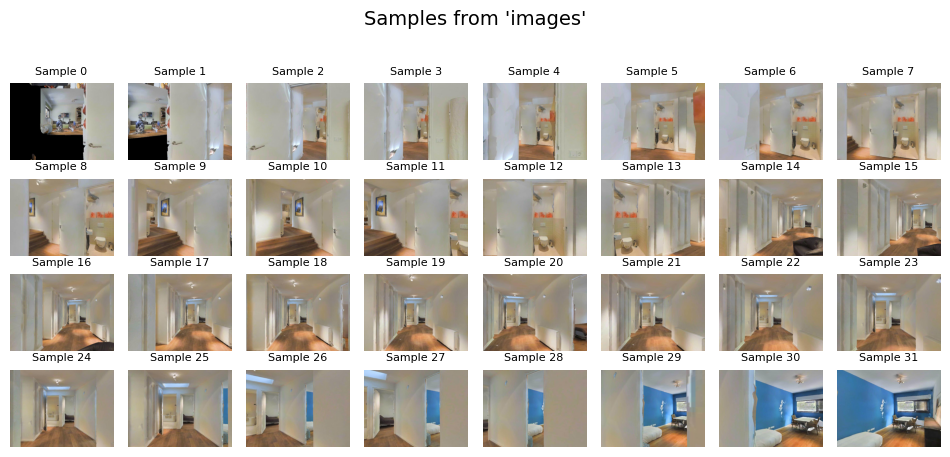

In [6]:
IMAGE_DIR_PATH = '/mnt/workspace/workgroup/ljp/RynnBrain/cookbooks/assets/navigation/images'

frames = sample_images_from_folder_and_show(IMAGE_DIR_PATH)


2.Generate messages



In [7]:
#Define the instruction
instruction = "exit the bedroom and turn left . walk down the hallway and enter the bedroom on the right . wait near the bed .messages"
messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": f"You are an autonomous navigation assistant. Your task is to {instruction}. Devise an action sequence to follow the instruction using the four actions: TURN LEFT (←) or TURN RIGHT (→) by 15 degrees, MOVE FORWARD (↑) by 25 centimeters, or STOP."},
            {"type": "text", "text": "you can see "},
            {
                "type": "image",
                "image": frames[0],
            },
        ],
    }
]



inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_dict=True,
    return_tensors="pt"
)
inputs = inputs.to(model.device)

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]
print(output_text)

→→→→


3.Prepare Stream Inference Data



In [8]:
action_list = []
rgb_list = []
for each in output_text:    
    action_list.append(each)
rgb_list.append(frames[0])
print(action_list)


['→', '→', '→', '→']


4.Stream Inference



In [9]:
conversation_list = []
user_content = [] 

curr_rgb = frames[4]
num_future_steps = 4
history_frames = [i for i in range(0, max(0,len(rgb_list)-32), max(1, (len(rgb_list)-32)//8))]

sample_frames = [i for i in range(max(0, len(rgb_list)-32), len(rgb_list), 4)]

prompt = f"You are an autonomous navigation assistant. Your task is to <instruction>. Devise an action sequence to follow the instruction using the four actions: TURN LEFT (←) or TURN RIGHT (→) by 15 degrees, MOVE FORWARD (↑) by 25 centimeters, or STOP."



prompt_text = prompt.replace('<instruction>', instruction)
if history_frames:
    prompt_text += " These are your historical observations: "

user_content.append({"type": "text", "text": prompt_text})



for index in history_frames:
    width, height = rgb_list[index].size
    user_content.append({"type": "image", "image": rgb_list[index], "width": width, "height": height})

conversation_list.append({
    "role": "user",
    "content": user_content
})



for index in sample_frames:
    user_content = []
    assistant_content = []

    user_content.append({"type": "text", "text": 'You can see'})
    width, height = rgb_list[index].size
    user_content.append({"type": "image", "image": rgb_list[index], "width": width, "height": height})
    

    step_actions = action_list[index:index+num_future_steps]

    conversation_list.append({
    "role": "user",
    "content": user_content
    })


    assistant_content.append({"type": "text", "text": step_actions})

    conversation_list.append({
    "role": "assistant",
    "content": assistant_content
    })

width, height = curr_rgb.size

user_content = []
user_content.append({"type": "text", "text": " you can see "})
user_content.append({"type": "image", "image": curr_rgb, "width": width, "height": height})

conversation_list.append({
    "role": "user",
    "content": user_content
})

inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_dict=True,
    return_tensors="pt"
)
inputs = inputs.to(model.device)

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]
print(output_text)

→→→→
